In [19]:
import pandas as pd
import missingno as msno

In [29]:
scrapped = pd.read_csv('dataset/AirlineScrappedReview_Cleaned.csv')
display(scrapped.info())
display(scrapped.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

None

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
count,3575.000000,3515.000000,3515.000000,3476.000000,3476.000000
mean,4.790490,42.639473,-2.164986,40.550399,-1.118816
std,3.170323,17.022014,44.576587,18.723619,46.045735
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234
25%,2.000000,41.893320,-0.458780,39.739236,-0.458780
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765
75%,8.000000,51.467739,11.048029,51.467739,11.048029
max,10.000000,65.011873,151.208285,64.145981,174.550610


Passanger_Name        1
Flying_Date        2620
Route               766
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type        0
Class                 0
Start_Location      766
End_Location        766
Layover_Route      3091
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

<Axes: >

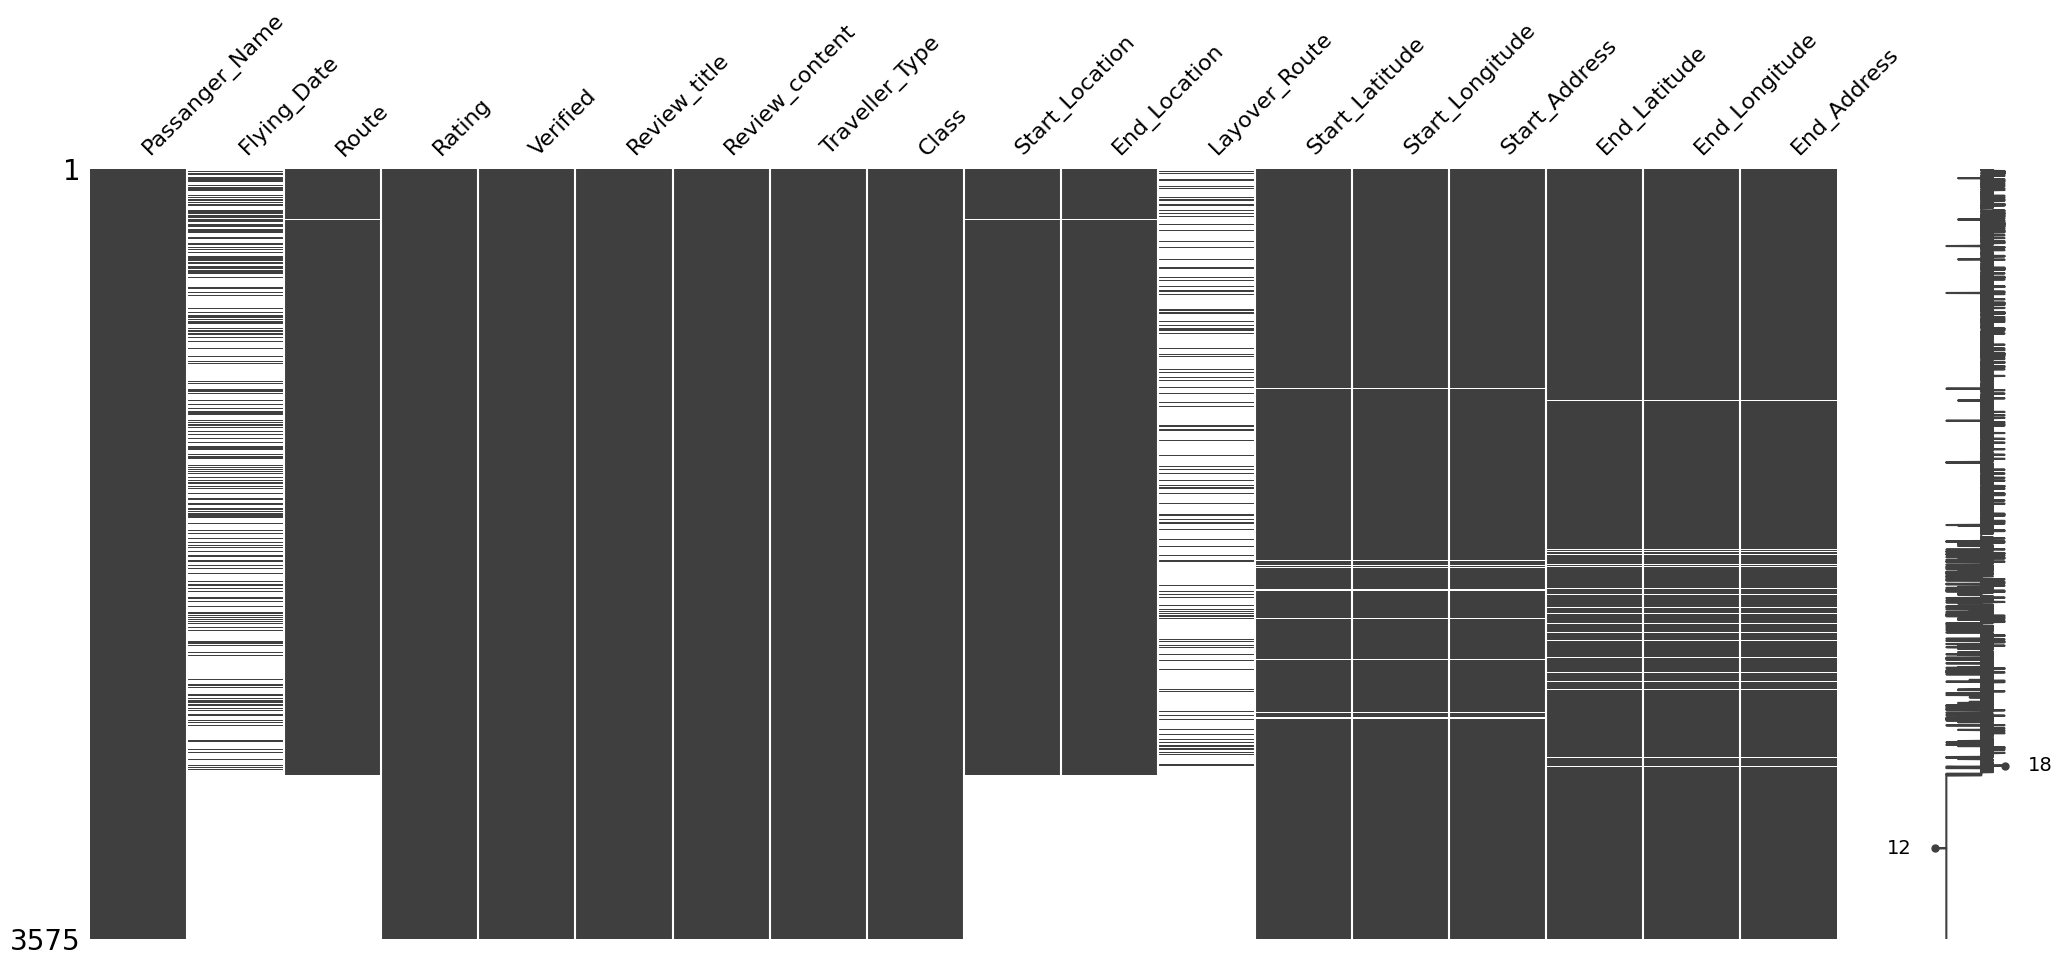

In [27]:
display(scrapped.isnull().sum())
display(msno.matrix(scrapped))